# Carga de librerias

In [699]:
import pandas as pd
import numpy as np

# Visualitation
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import joblib
import gzip

import json

# Importación de datos

In [700]:
data_raw = pd.read_csv('raw_data/Train Data.csv')
data_raw.columns

Index(['ID', 'label', 'edad', 'montoSolicitado', 'montoOtorgado', 'genero',
       'quincenal', 'dependientesEconomicos', 'nivelEstudio', 'fico',
       'ingresosMensuales', 'gastosMensuales', 'emailScore', 'browser',
       'NUMTDC_AV'],
      dtype='object')

# EDA

In [701]:
data_raw.shape

(1000, 15)

In [702]:
data_raw.dtypes

ID                          int64
label                       int64
edad                      float64
montoSolicitado           float64
montoOtorgado             float64
genero                     object
quincenal                   int64
dependientesEconomicos      int64
nivelEstudio               object
fico                        int64
ingresosMensuales         float64
gastosMensuales             int64
emailScore                float64
browser                    object
NUMTDC_AV                 float64
dtype: object

In [703]:
data_raw.head()

,ID,label,edad,montoSolicitado,montoOtorgado,genero,quincenal,dependientesEconomicos,nivelEstudio,fico,ingresosMensuales,gastosMensuales,emailScore,browser,NUMTDC_AV
0,1,0,38.0,11890.0,11890.0,Hombre,0,1,Universidad,561,7000.0,7000,0.0,CHROME9,1.0
1,2,0,26.0,3700.0,3700.0,Hombre,1,0,Preparatoria,649,8000.0,3000,0.0,CHROME9,1.0
2,3,0,28.0,13980.0,13980.0,Hombre,0,0,Universidad,575,7500.0,2000,NaN,NaN,3.0
3,4,0,27.0,12016.0,6286.0,Hombre,0,0,Universidad,651,12800.0,4300,1.0,UNKNOWN,NaN
4,5,0,31.0,20000.0,12000.0,Hombre,1,1,Universidad,444,20000.0,12000,1.0,MOBILE_SAFARI,NaN


In [704]:
data_raw.describe()
# NUMTDC_AV NA == a cero

,ID,label,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore,NUMTDC_AV
count,1000.000000,1000.000000,996.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,873.000000,506.000000
mean,500.500000,0.220000,34.588353,15871.090740,11871.470470,0.156000,0.995000,533.60800,24852.949160,12692.456000,1.882016,2.203557
std,288.819436,0.414454,10.176296,17109.302264,12951.028413,0.363037,1.127939,141.94502,38290.063995,28816.956572,5.325080,1.518228
min,1.000000,0.000000,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.00000,12.000000,2.000000,0.000000,1.000000
25%,250.750000,0.000000,27.000000,5289.500000,4393.750000,0.000000,0.000000,491.00000,10000.000000,4000.000000,0.000000,1.000000
50%,500.500000,0.000000,32.000000,11000.000000,7795.000000,0.000000,1.000000,560.00000,16000.000000,7000.000000,1.000000,2.000000
75%,750.250000,0.000000,40.000000,19000.000000,15000.000000,0.000000,2.000000,618.25000,25000.000000,14000.000000,1.000000,3.000000
max,1000.000000,1.000000,69.000000,150000.000000,100000.000000,1.000000,5.000000,748.00000,900000.000000,750000.000000,80.000000,12.000000


In [705]:
data_raw.describe(include=[object])

,genero,nivelEstudio,browser
count,1000,1000,871
unique,2,7,12
top,Hombre,Universidad,CHROME_MOBILE
freq,719,534,437


In [706]:
data_raw['genero'].unique().tolist()

['Hombre', 'Mujer']

In [707]:
data_raw['nivelEstudio'].unique().tolist()
# tenemos un error de tipo en 'Maestr√≠a'

['Universidad',
 'Preparatoria',
 'Maestr√≠a',
 'Secundaria',
 'Primaria',
 'Doctorado',
 'Ninguno']

In [708]:
data_raw['browser'].unique().tolist()
# mas a delante manejaremos esos nan
# observamos que podemos saber si es desde un movil desde donde ocurre la conexión sera interesante ver si existe una correlación

['CHROME9',
 nan,
 'UNKNOWN',
 'MOBILE_SAFARI',
 'CHROME_MOBILE',
 'CHROME8',
 'APPLE_WEB_KIT',
 'FIREFOX8',
 'MOZILLA',
 'FIREFOX_MOBILE',
 'CHROME',
 'SAFARI',
 'EDGE_MOBILE']

El tipo de columnas es consistentes con lo que contienen

## Limpieza 

In [709]:
# no necesitamos la columna ID
data_clean = data_raw.drop(columns=['ID'])

# Para temas de visualizacion y de cohort cambiaremos label
data_clean['label'] = data_clean['label'].apply(lambda x: 'Moroso' if x == 1 else 'No Moroso')

# corregimos "Maestr√≠a" a "Maestria"
data_clean['nivelEstudio'] = data_clean.nivelEstudio.replace("Maestr√≠a", "Maestria")


### Manejo de datos faltantes

In [710]:
# NAs por columna
data_clean.isnull().sum() 

label                       0
edad                        4
montoSolicitado             0
montoOtorgado               0
genero                      0
quincenal                   0
dependientesEconomicos      0
nivelEstudio                0
fico                        0
ingresosMensuales           0
gastosMensuales             0
emailScore                127
browser                   129
NUMTDC_AV                 494
dtype: int64

Text(0.5, 1.0, 'NAs ratio per Column')

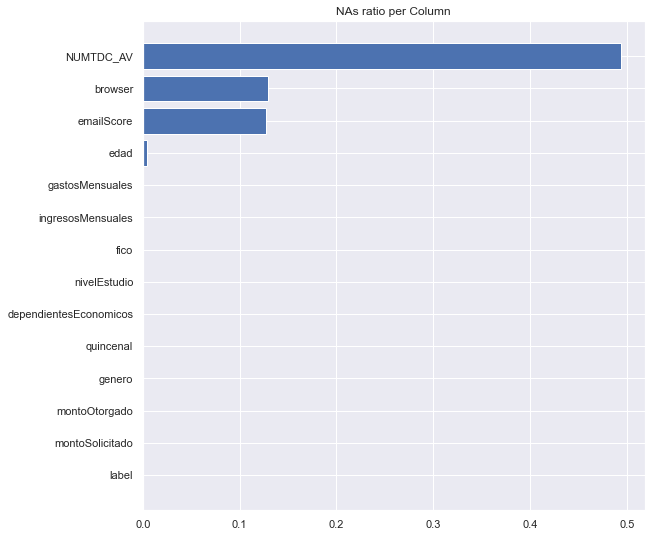

In [711]:
# Create a data frame
df = pd.DataFrame ({
        'column':  data_clean.isna().sum().index,
        'NAs': (data_clean.isna().sum()/data_clean.shape[0])
}).sort_values(by=['NAs'])

fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(y=df.column, width=df.NAs)

# Add title
ax.set_title('NAs ratio per Column')

#### Imputacion de NAs

Son 4 columnas las que presentan NAs. 
Para el caso de 'edad' al ser solo 4 datos nulos tomaremos su promedio para imputar 
Para 'emailScore' los datos nulos seran tratados como ceros ya que esto es equivalente a no tener confianza sobre ese email
Para 'browser' utilizaremos la categoria 'UNKNOWN' que ya existe
En el caso de NUMTDC_AV partiremos de algunos supuestos el primero como vemos https://blog.kardmatch.com.mx/cuantas-tarjetas-de-credito-es-recomendable-tener, https://www.bbva.com/es/cuantas-tarjetas-credito-conviene/, las recomendaciones son al menos dos tarejtas de credito y https://www.nerdwallet.com/article/finance/how-many-credit-cards mencionan que en promedio un estadunidense tiene un promedio de 2.3  tarjetas de credito ( curisoasmente muy cercano al 2.2 de nuestros datos) y tomando en cuenta que el consumo tiende a parecerce entre paises la columna NUMTDC_AV la convertiremos en una varible categorica con 3 catergorias 'UNKNOWN' '3 o menos tarjetas de credito' 'mas de 3 tarjetas' se selecciona 3 tarjetas y no 2 como nuestro limite ya que con las nuevas tarjetas 'sin anualidad' existen más incentivos para adquirir cada vez más

In [712]:
# Estas imputaciones se pueden realizar dentro del pipline de sklearn sin embargo para tener un mejor control y dado 
# que son pocas las columnas se tratara una a una

def clean_data(data):

    # emailScore
    data['emailScore'] = data['emailScore'].fillna(0)

    # browser
    data['browser'] = data['browser'].fillna("UNKNOWN")

    #  NUMTDC_AV
    cond_list = [data['NUMTDC_AV']  <= 3, data['NUMTDC_AV']  > 3]
    choice_list = ['3 o menos TC', 'Mas de 3 TC']

    data['NUMTDC_AV'] = np.select(cond_list, choice_list, default='UNKNOWN')

    return data


In [713]:
data_clean = clean_data(data_clean)


In [714]:
data_clean.describe()
# NUMTDC_AV pasa a ser categorica

,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore
count,996.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,34.588353,15871.090740,11871.470470,0.156000,0.995000,533.60800,24852.949160,12692.456000,1.643000
std,10.176296,17109.302264,12951.028413,0.363037,1.127939,141.94502,38290.063995,28816.956572,5.014449
min,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.00000,12.000000,2.000000,0.000000
25%,27.000000,5289.500000,4393.750000,0.000000,0.000000,491.00000,10000.000000,4000.000000,0.000000
50%,32.000000,11000.000000,7795.000000,0.000000,1.000000,560.00000,16000.000000,7000.000000,1.000000
75%,40.000000,19000.000000,15000.000000,0.000000,2.000000,618.25000,25000.000000,14000.000000,1.000000
max,69.000000,150000.000000,100000.000000,1.000000,5.000000,748.00000,900000.000000,750000.000000,80.000000


In [715]:
data_clean.describe(include=[object])

,label,genero,nivelEstudio,browser,NUMTDC_AV
count,1000,1000,1000,1000,1000
unique,2,2,7,12,3
top,No Moroso,Hombre,Universidad,CHROME_MOBILE,UNKNOWN
freq,780,719,534,437,494


Veamos graficamente las variables categoricas

In [716]:
def categorical_plot(column):
    df = data_clean[column].value_counts()
    df.sort_values().plot(kind='barh', title = column.upper())

In [717]:
data_clean['label'].value_counts()

No Moroso    780
Moroso       220
Name: label, dtype: int64

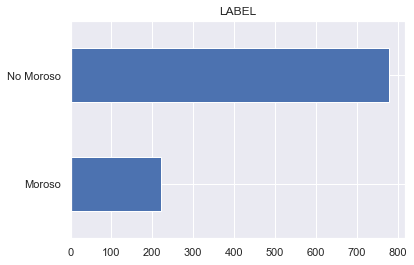

In [718]:
categorical_plot('label')

Estamos frente a un problema de clasificacion desvalanceado ya que el tipo de usuario "Moroso" (clase positiva)
mantiene una relacionde  0.282 respecto a "No Moroso" (clase negativa)

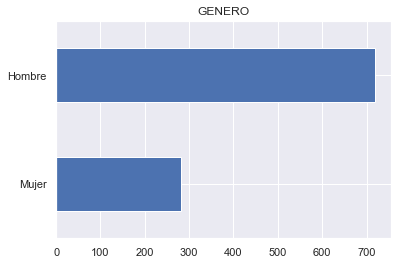

In [719]:
categorical_plot('genero')

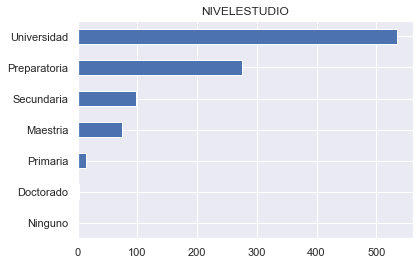

In [720]:
categorical_plot('nivelEstudio')

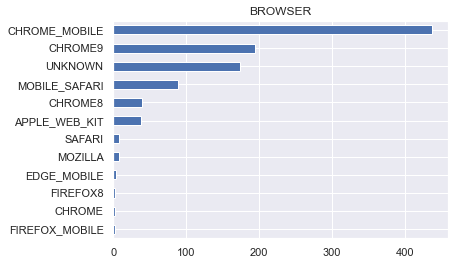

In [721]:
categorical_plot('browser')

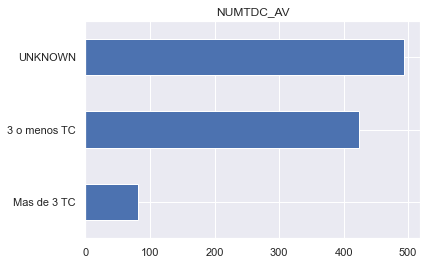

In [722]:
categorical_plot('NUMTDC_AV')

## Correlación

Veamos como se comportan los datos de acuerdo a cada label

In [723]:
data_clean[data_clean['label']=='Moroso'].describe()

,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,31.754545,17503.284000,11070.984409,0.150000,1.022727,516.363636,20749.836364,10696.136364,1.881818
std,9.119387,20078.066392,13527.928377,0.357886,1.140549,131.289372,21134.361626,12429.727442,3.024200
min,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.000000,1000.000000,400.000000,0.000000
25%,25.000000,5875.000000,4000.000000,0.000000,0.000000,464.000000,10000.000000,4000.000000,0.000000
50%,30.000000,12000.000000,7000.000000,0.000000,1.000000,537.000000,15000.000000,6750.000000,1.000000
75%,36.000000,19072.500000,14021.000000,0.000000,2.000000,602.000000,25000.000000,13000.000000,1.000000
max,67.000000,150000.000000,100000.000000,1.000000,4.000000,710.000000,150000.000000,80000.000000,14.000000


In [724]:
data_clean[data_clean['label']=='No Moroso'].describe()

,edad,montoSolicitado,montoOtorgado,quincenal,dependientesEconomicos,fico,ingresosMensuales,gastosMensuales,emailScore
count,776.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,35.391753,15410.728538,12097.248590,0.157692,0.987179,538.471795,26010.237385,13255.520513,1.575641
std,10.321222,16158.668466,12783.504608,0.364686,1.124971,144.516752,41815.285113,31938.391897,5.445557
min,18.000000,1000.000000,1000.000000,0.000000,0.000000,0.000000,12.000000,2.000000,0.000000
25%,27.000000,5182.220000,4476.825000,0.000000,0.000000,497.000000,10000.000000,4500.000000,0.000000
50%,33.000000,11000.000000,8000.000000,0.000000,1.000000,568.000000,16000.000000,7500.000000,1.000000
75%,41.000000,19000.000000,15200.000000,0.000000,2.000000,622.000000,28000.000000,15000.000000,1.000000
max,69.000000,150000.000000,100000.000000,1.000000,5.000000,748.000000,900000.000000,750000.000000,80.000000


De las tablas anteriores se destaca que el 50% de los usuarios y en su promedio
tienden a pedir un monto mayor respecto a los usuarios que no son morosos

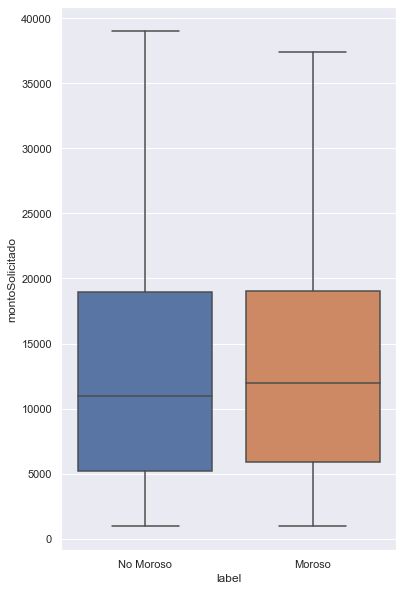

In [725]:
sns.set(style="darkgrid")
plt.figure(figsize=(6, 10))
sns.boxplot(x=data_clean["label"], y=data_clean["montoSolicitado"], showfliers = False)
plt.show()

De igual manera destaca que los usuarios morosos tienen un ingreso menor


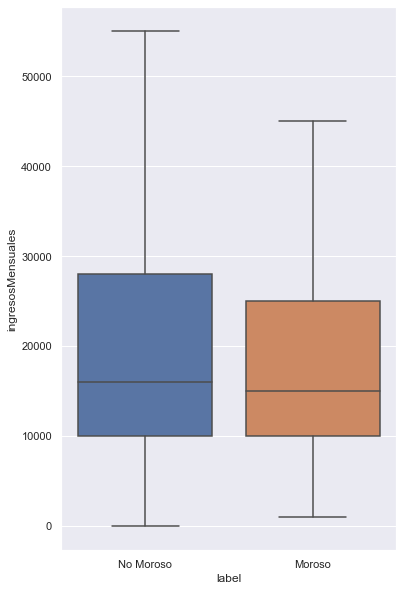

In [726]:
plt.figure(figsize=(6, 10))
sns.boxplot(x=data_clean["label"], y=data_clean["ingresosMensuales"], showfliers = False)
plt.show()


Para el caso de gastosMensuales se debe de tener cierta precaucion ya que se observa que los usuarios morosos gastan menos, sin embargo es importante 
tomar en cuenta que al tener un ingreso menor es natural que sus gastos sean menores, por lo tanto encontraremos la proporción de gasto vs ingreso 

In [727]:
data_clean['Proporción de gasto'] = data_clean['gastosMensuales']/data_clean['ingresosMensuales']

data_clean.groupby('label')['Proporción de gasto'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Moroso,220.0,0.664243,1.288290,0.033333,0.349457,0.5,0.6,10.0
No Moroso,780.0,0.490723,0.314685,0.000360,0.347826,0.5,0.6,7.5


De lo anterior podemos destacar que los usuarios Morosos gastan en promedio un 0.664 de su ingreso, mayor al 0.49 de los usaurios No Morosos

Veamos la distribucion del nivel de estudios

In [728]:
def plot_ratio_by_column_and_label(colum):
    """Help to plot categorical columns"""
    group_by_label_and_column = (
    data_clean.groupby(['label'])[colum]
    .value_counts()
    .reset_index(name='count')
    )

    group_by_label_and_column['ratio'] = (
        group_by_label_and_column
        .groupby('label')['count']
        .apply(lambda x: x/x.sum())
    )

    sns.set(style="darkgrid")
    g = sns.FacetGrid(group_by_label_and_column, col="label", height=6, col_wrap=1, hue="label", aspect=.85)
    g.map(sns.barplot, "ratio", colum)
    plt.show()



e:\Documents\pruebas\atrato\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


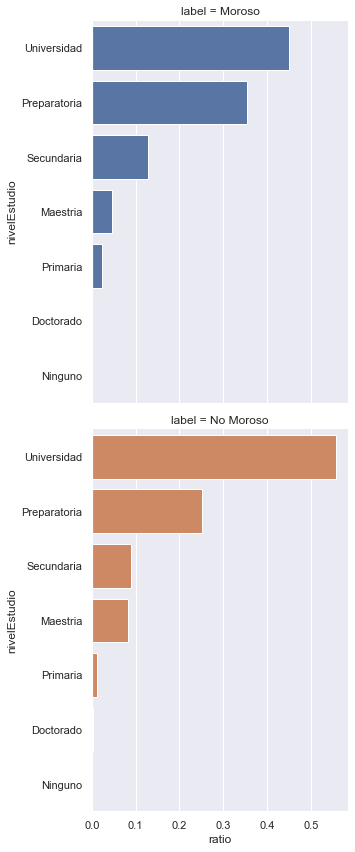

In [729]:
plot_ratio_by_column_and_label("nivelEstudio")

Lo usuarios que No Morosos en su maypria tinen la universidad

e:\Documents\pruebas\atrato\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


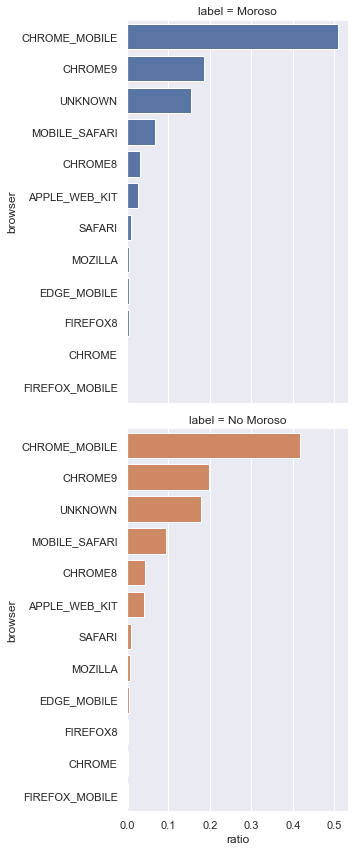

In [730]:
plot_ratio_by_column_and_label('browser')

Ambos tipos de usurios tienen una distribucion similar, se puede destacar que los usuarios Morosos se conectan en su mayoria por CHROME_MOBILE

e:\Documents\pruebas\atrato\venv\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


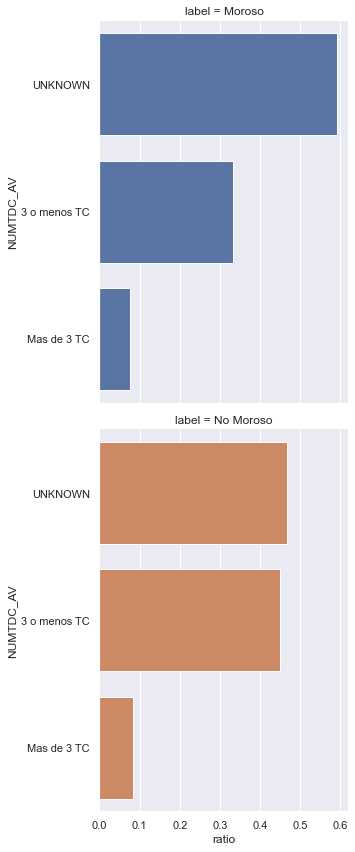

In [731]:
plot_ratio_by_column_and_label("NUMTDC_AV")

Genial ya tenemos ciertas caracteristicas generales de los datos ahora toca crear un modelo 

# Modelado

Al ser un modelo de clasificacion binaria supervisada, el primero modelo que viene a la mente es un la regresion logistica que 
usualmente en la literatura es el primer modelo que se confronta a este tipo de problema.

Por lo que la regresion logistica sera nuestro punto de partida para comparar con otros modelos y conocer si existe mejoria o no 
con cada nuevo modelo

Al hablar de "mejor" o "peor" respecto a cada modelo nos basaremos en "F1 score" ya que este es un problema de clasificacion 
desvalanceado https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc, 

## Preprosesamiento

In [732]:
from sklearn.model_selection import train_test_split

X = data_clean.drop(['label'], axis=1)
#Lo convertimos en binario cómo originalmente se encontraba
y = data_clean.label.apply(lambda x: 1 if x == 'Moroso' else 0)


X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=.3,random_state=100, stratify=y)

Nos apoyaremos de los pipeline de sklearn los cuales nos ayudan a simplicar mucho todo el proceso de entrenamiento

In [733]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

# Para el escalado de las variables nuemericas usaremos MinMaxScaler
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

# handle_unknown='ignore' es muy importante por si se introduce una categoria que no se encontraba durante el po
# proceso de entrenamiento
categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

from sklearn.compose import ColumnTransformer
numerical_features = X_train.select_dtypes(include=['number']).columns
categorical_features = X_train.select_dtypes(exclude=['number']).columns

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])


Con el pipeline anterior es más sencillo el preprosesamiento y nos enfocaremos en la seleccion del modelo

## Regresion Logistica

Este es nuestro primero modelo y sera nuestro 'baseline' para hacer contraste en la mejora de cada nuevo modelo

In [734]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, fbeta_score

logisticregression = LogisticRegression()

logisticregression_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', logisticregression)
])

In [735]:
_ = logisticregression_pipeline.fit(X_train, y_train)

Una vez ajustado el modelo un paso importante es encontrar el mejor 'threshold'
por lo tanto en busqueda de optimizar nuestro F1 score nos apoyaremos de distintos modelos y cada uno con distintos 'thresholds'

In [736]:
from sklearn.metrics import confusion_matrix

def get_f1_by_threshold(threshold, model_pipline):
    """Calcula el F1 para distintos threshold"""
    y_pred_pos = model_pipline.predict_proba(X_valid)[:,1] # probabilidades de pertenecer a la clase 1
    y_pred_class = y_pred_pos > threshold

    return (f1_score(y_valid, y_pred_class))


def threshold_f1_plot(model_pipeline, show_plot = True):
    """Grafica el f1 para cada threshold del modelo"""
    f1_values = [get_f1_by_threshold(threshold, model_pipeline) for threshold in np.linspace(0,1,100)]

    df = pd.DataFrame({
        'f1_values':f1_values, 
        'threshold': np.linspace(0,1,100)}
        )

    f1_value, threshold = df.sort_values('f1_values', ascending = False).iloc[0]

    if show_plot:
        
        plt.figure(figsize = (15, 5))
        plt.axvline(threshold, color='r', linestyle='--')
        plt.text(threshold+0.02, f1_value, f"f1_value : {round(f1_value, 3)} threshold : {round(threshold, 3)} ", horizontalalignment='left', size='medium', color='black', weight='semibold')
        sns.lineplot(x=df['threshold'], y=df['f1_values'])
        sns.scatterplot(x=df['threshold'], y=df['f1_values'])
        plt.show()


    return f1_value, threshold 


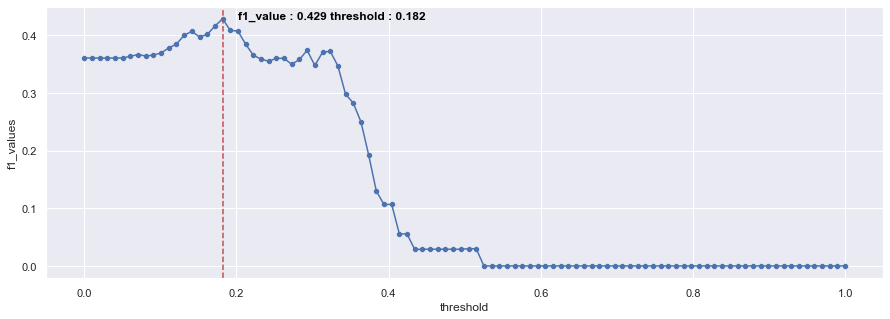

In [737]:
f1_value, threshold  = threshold_f1_plot(logisticregression_pipeline)

In [738]:
# al obtener el threshold con el mayor F1 procedemos a clasificar a cada usuario
y_pred_prob = logisticregression_pipeline.predict_proba(X_valid)[:,1] # probabilidades de pertenecer a la clase 1
y_pred_class = y_pred_prob > threshold
cm = confusion_matrix(y_valid, y_pred_class)
print(cm)

[[113 121]
 [ 15  51]]


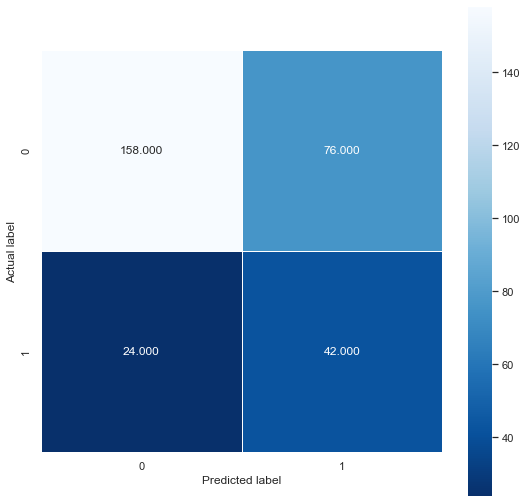

In [747]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = logisticregression_pipeline.score(X_valid, y_valid)

# al tener un mayor tenemos una alta garantia de qu pagaran de verdaderos negaticvos 

## linear SVM
## Naive bayes

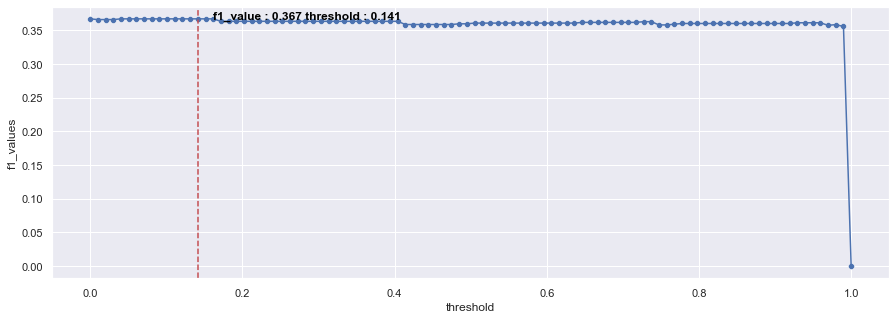

In [740]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', gnb)
])
 
gnb_pipeline.fit(X_train, y_train)

f1_value, threshold  = threshold_f1_plot(gnb_pipeline)

## KNeighborsClassifier

Para el caso de knn el principal problema es la seccion correcta del valor de k nos limitaremos a solo seleccionar 3 valores de k
20, 30 y 40

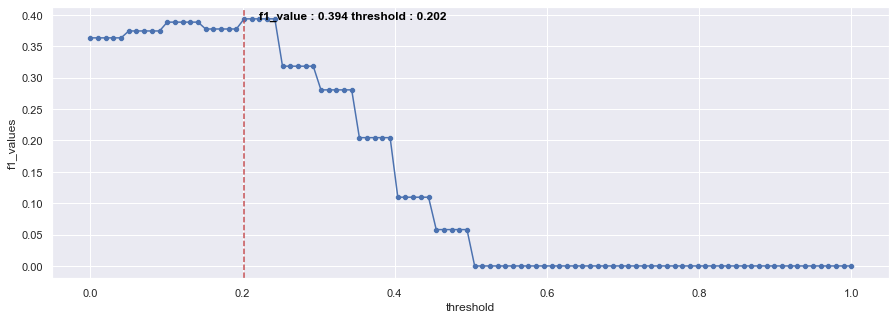

In [741]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)  

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', knn)
])

_ = knn_pipeline.fit(X_train, y_train)

f1_value, threshold  = threshold_f1_plot(knn_pipeline)

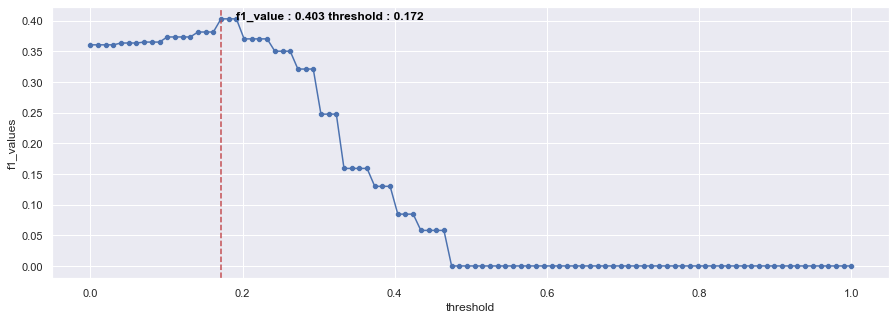

In [742]:
knn = KNeighborsClassifier(n_neighbors=30)  

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', knn)
])

_ = knn_pipeline.fit(X_train, y_train)

f1_value, threshold  = threshold_f1_plot(knn_pipeline)

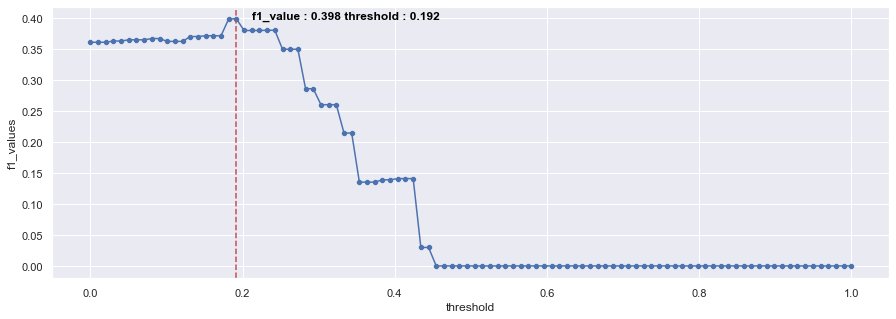

In [743]:
knn = KNeighborsClassifier(n_neighbors=40)  

knn_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', knn)
])

_ = knn_pipeline.fit(X_train, y_train)

f1_value, threshold  = threshold_f1_plot(knn_pipeline)

de los 3 el mejor es con k = 30

## RandomForestClassifier

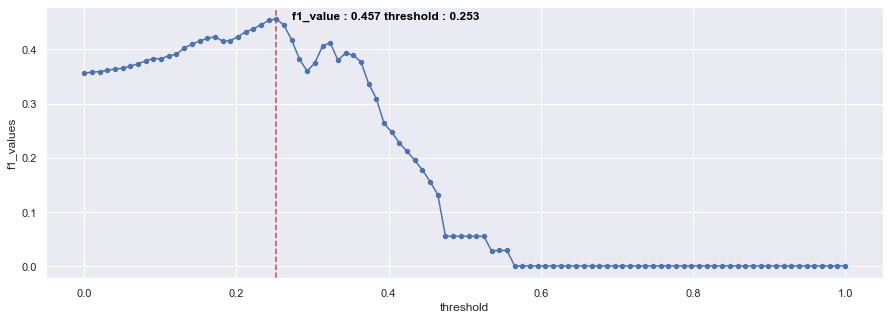

In [744]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=20)  


rf_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', rf)
])

rf_pipeline.fit(X_train, y_train)

f1_value, threshold  = threshold_f1_plot(rf_pipeline)


In [745]:
y_pred_pos = rf_pipeline.predict_proba(X_valid)[:,1] # probabilidades de pertenecer a la clase 1
y_pred_class = y_pred_pos > threshold
cm = confusion_matrix(y_valid, y_pred_class)
print(cm)

[[158  76]
 [ 24  42]]


In [746]:
pd.DataFrame({'ids':y_valid, 'label':y_pred_class.astype(int)})[:40]

,ids,label
287,0,0
327,1,0
343,0,0
416,0,1
8,1,0
845,0,1
476,0,0
943,0,0
149,1,1
732,0,1


## lightgbm

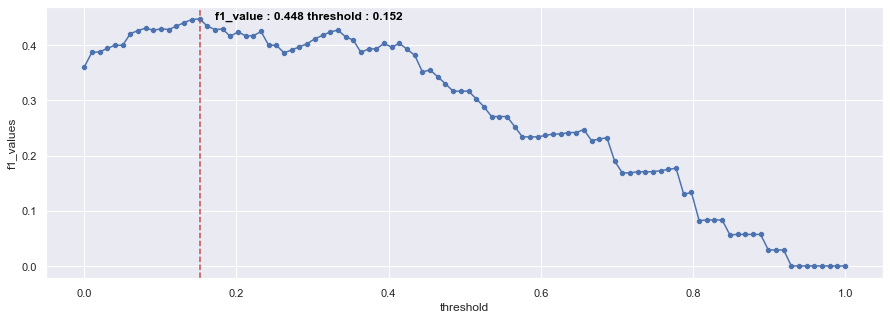

In [373]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier()

lgbmc_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', lgbmc)
])

lgbmc_pipeline.fit(X_train, y_train)
f1_value, threshold  = threshold_f1_plot(lgbmc_pipeline)

In [429]:
y_pred_pos = rf_pipeline.predict_proba(X_valid)[:,1] # probabilidades de pertenecer a la clase 1
y_pred_class = y_pred_pos > threshold
cm = confusion_matrix(y_valid, y_pred_class)
print(cm)

[[ 75 159]
 [  7  59]]


In [451]:
pd.DataFrame({'ids':y_valid, 'label':y_pred_class.astype(int)})

,ids,label
287,0,0
327,1,1
343,0,0
416,0,1
8,1,0
...,...,...
641,0,1
117,0,1
279,0,1
955,0,1


# Guardado del mejor modelo

Al comparar los ditintos modelos observamos que el que tuvo un mejor comportamiento (mayor valor de F1)
fue Random Forest por lo tanto este es el modelo usado en producción

In [299]:
joblib.dump(rf_pipeline, gzip.open('model/model_binary_class.dat.gz', "wb"))

rf_pipeline.fit(X_train, y_train)

# Guardamos el f1 actual del modelo así como el mejor threshold

f1_value, threshold  = threshold_f1_plot(rf_pipeline, show_plot = False)

data = {
    'f1_value' : f1_value,
    'threshold' : threshold,
        }

with open('model/model_outputs.json', 'w') as outfile:
    json.dump(data, outfile, indent=4)

# Conclusiones 

Una vez explorado los modelos anteriores sin hacer una optimizacion de parametros tienden a comportarse de manera muy similar
sin embargo el modelo seleccionado es el de Random Forest ya que mostro un mayor F1 score

# Prediccion para Test Data

Ahora toca hacer la predicción de los 'Test Data'

In [748]:
# Cargamos
test_data = pd.read_csv('raw_data/Test Data.csv')
test_data_clean = clean_data(test_data)
test_data_clean


,ID,edad,montoSolicitado,montoOtorgado,genero,quincenal,dependientesEconomicos,nivelEstudio,fico,ingresosMensuales,gastosMensuales,emailScore,browser,NUMTDC_AV
0,1,30.0,20000.0,40000.0,Hombre,1,0,Universidad,575,25000.0,15000,1.0,UNKNOWN,3 o menos TC
1,2,31.0,2000.0,2000.0,Hombre,0,4,Preparatoria,635,12000.0,8000,8.0,CHROME9,UNKNOWN
2,3,29.0,15000.0,15000.0,Mujer,0,0,Universidad,568,20000.0,14000,0.0,CHROME_MOBILE,3 o menos TC
3,4,20.0,7000.0,6000.0,Mujer,0,1,Preparatoria,643,2000.0,6000,1.0,CHROME_MOBILE,UNKNOWN
4,5,34.0,18000.0,12999.0,Hombre,1,1,Universidad,546,50000.0,30000,0.0,APPLE_WEB_KIT,3 o menos TC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,296,27.0,1779.0,1779.0,Mujer,1,0,Universidad,511,38000.0,20000,8.0,CHROME9,Mas de 3 TC
296,297,36.0,19700.0,19700.0,Mujer,0,0,Universidad,491,32000.0,17000,0.0,CHROME_MOBILE,3 o menos TC
297,298,49.0,6000.0,3000.0,Hombre,1,1,Preparatoria,521,6000.0,3500,0.0,CHROME9,3 o menos TC
298,299,29.0,3000.0,3000.0,Mujer,0,1,Universidad,529,10000.0,6000,1.0,CHROME_MOBILE,3 o menos TC


In [749]:
# no necesitamos la columna ID
ids = test_data_clean.pop('ID')
# creamos la columna Proporción de gasto
test_data_clean['Proporción de gasto'] = test_data_clean['gastosMensuales']/test_data_clean['ingresosMensuales']
y_pred_pos = rf_pipeline.predict_proba(test_data_clean)[:,1] # probabilidades de pertenecer a la clase 1
y_pred_class = y_pred_pos > threshold
y_pred_class

pd.DataFrame({'ids':ids, 'label':y_pred_class.astype(int)})

,ids,label
0,1,0
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
295,296,1
296,297,1
297,298,1
298,299,1


In [751]:
y_pred_class.mean()

0.38333333333333336

#
take away 
crear la columna is_mobile